Archivo input: (Datos/Originales/Datos UX/page_views_2.csv)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "Datos/Originales/Datos UX/page_views_2.csv"
SEP = ";"


# CARGA DATOS

In [2]:
df = pd.read_csv(DATA_PATH, sep=SEP)

df["event_timestamp_"] = pd.to_datetime(df["event_timestamp_"], errors="coerce")
df = df.dropna(subset=["event_timestamp_"])
df = df.sort_values(["user_id", "event_timestamp_"]).copy()


In [3]:
rows_clean = df.shape[0]
users_n = df["user_id"].nunique()
sections_n = df["section"].nunique()

dup_count = df.duplicated(subset=["user_id","section","event_timestamp_"]).sum()

events_per_user = df.groupby("user_id").size()

dq_table = pd.DataFrame({
    "metric": [
        "Filas tras limpieza",
        "Usuarias únicas",
        "Secciones únicas (mapeadas)",
        "Duplicados restantes (user+section+timestamp)",
        "Eventos/usuaria (min)",
        "Eventos/usuaria (mediana)",
        "Eventos/usuaria (p90)",
        "Eventos/usuaria (max)",
    ],
    "value": [
        rows_clean,
        users_n,
        sections_n,
        dup_count,
        int(events_per_user.min()),
        float(events_per_user.median()),
        float(events_per_user.quantile(0.90)),
        int(events_per_user.max()),
    ]
})

display(dq_table)

,metric,value
0,Filas tras limpieza,794.0
1,Usuarias únicas,41.0
2,Secciones únicas (mapeadas),19.0
3,Duplicados restantes (user+section+timestamp),0.0
4,Eventos/usuaria (min),1.0
5,Eventos/usuaria (mediana),18.0
6,Eventos/usuaria (p90),26.0
7,Eventos/usuaria (max),57.0


In [4]:
# Mapeo de secciones (orden del quiz)
STEP_ORDER_MAP = {
    "quiz_leisure": 1,
    "quiz_work": 2,
    "quiz_fit": 3,
    "quiz_highlight": 4,
    "quiz_bodyShape": 5,
    "quiz_eyes": 6,
    "quiz_hair": 7,
    "quiz_sizes": 8,
    "quiz_measurements": 9,
    "quiz_focus": 10,
    "quiz_adventurous": 11,
    "quiz_styles": 12,
    "quiz_prices": 13,
    "quiz_avoid": 14,
    "quiz_footwear": 15,
    "quiz_you": 16,
    "quiz_photos": 17,
    "quiz_social": 18,
    "quiz_signUp": 19,
}
INV_STEP_ORDER_MAP = {v: k for k, v in STEP_ORDER_MAP.items()}

# Asignación del paso
df["step_order"] = df["section"].map(STEP_ORDER_MAP)
df = df[df["step_order"].notna()].copy()

# Deduplicado por evento (mismo user + sección + timestamp)
df = df.drop_duplicates(subset=["user_id", "section", "event_timestamp_"])



# FUNNEL

In [5]:
# Primer timestamp en el que cada user ve cada sección
first_views = (
    df.groupby(["user_id", "section"], as_index=False)
      .agg(first_time=("event_timestamp_", "min"))
)
first_views["step_order"] = first_views["section"].map(STEP_ORDER_MAP)

# Usuarias únicas por paso
funnel = (
    first_views.groupby("step_order")
    .agg(users=("user_id", "nunique"))
    .reset_index()
    .sort_values("step_order")
)
funnel["section"] = funnel["step_order"].map(INV_STEP_ORDER_MAP)

# Totales y tasas
total_users = first_views["user_id"].nunique()
funnel["from_start_rate"] = funnel["users"] / total_users
funnel["from_prev_rate"] = funnel["users"] / funnel["users"].shift(1)

display(funnel)


,step_order,users,section,from_start_rate,from_prev_rate
0,1,16,quiz_leisure,0.390244,NaN
1,2,37,quiz_work,0.902439,2.312500
2,3,37,quiz_fit,0.902439,1.000000
3,4,36,quiz_highlight,0.878049,0.972973
4,5,36,quiz_bodyShape,0.878049,1.000000
5,6,36,quiz_eyes,0.878049,1.000000
6,7,36,quiz_hair,0.878049,1.000000
7,8,36,quiz_sizes,0.878049,1.000000
8,9,36,quiz_measurements,0.878049,1.000000
9,10,36,quiz_focus,0.878049,1.000000


In [6]:
# con que pantalla empieza cada usuaria
first_section_per_user = df.sort_values("event_timestamp_").groupby("user_id").first()["section"]
first_section_per_user.value_counts()

section
quiz_work       27
quiz_leisure    13
quiz_signUp      1
Name: count, dtype: int64

## ANALIZAR TIEMPOS POR PASO

In [7]:
fv_sorted = first_views.sort_values(["user_id", "step_order"]).copy()
fv_sorted["next_time"] = fv_sorted.groupby("user_id")["first_time"].shift(-1)
fv_sorted["time_to_next"] = (fv_sorted["next_time"] - fv_sorted["first_time"]).dt.total_seconds()

# Mediana por paso
time_stats = (
    fv_sorted.groupby("step_order")
    .agg(median_time_to_next=("time_to_next", "median"))
    .reset_index()
    .sort_values("step_order")
)
time_stats["section"] = time_stats["step_order"].map(INV_STEP_ORDER_MAP)
display(time_stats)

# Percentiles por paso (p50/p75/p90)
time_dist = (
    fv_sorted.dropna(subset=["time_to_next"])
    .groupby("step_order")["time_to_next"]
    .quantile([0.5, 0.75, 0.9])
    .unstack()
    .reset_index()
)
time_dist.columns = ["step_order", "p50", "p75", "p90"]
time_dist["section"] = time_dist["step_order"].map(INV_STEP_ORDER_MAP)
display(time_dist.sort_values("p50", ascending=False).head(10))



,step_order,median_time_to_next,section
0,1,8.864713,quiz_leisure
1,2,9.816954,quiz_work
2,3,18.482816,quiz_fit
3,4,20.856579,quiz_highlight
4,5,34.177424,quiz_bodyShape
5,6,11.363381,quiz_eyes
6,7,8.616449,quiz_hair
7,8,31.851825,quiz_sizes
8,9,13.657588,quiz_measurements
9,10,19.151518,quiz_focus


,step_order,p50,p75,p90,section
11,12,65.715336,96.792416,153.613794,quiz_styles
16,17,54.285818,424.203517,978.368456,quiz_photos
4,5,34.177424,56.361351,72.565701,quiz_bodyShape
7,8,31.851825,41.563064,70.328990,quiz_sizes
14,15,28.292077,51.189484,79.713048,quiz_footwear
10,11,26.651334,35.899500,68.032105,quiz_adventurous
3,4,20.856579,29.401042,51.454520,quiz_highlight
15,16,20.621964,35.097698,51.397986,quiz_you
13,14,19.861490,29.672854,45.385642,quiz_avoid
9,10,19.151518,24.770124,33.024377,quiz_focus


## Detectar backtracking o bucles (usuario se lía)
Mirar si las usuarias van hacia atrás en el cuestionario (por ejemplo, dejan quiz_styles y vuelven a quiz_fit):

In [8]:
df_sorted = df.sort_values(["user_id", "event_timestamp_"]).copy()
df_sorted["prev_step"] = df_sorted.groupby("user_id")["step_order"].shift(1)

# Backtrack: paso actual menor que el anterior
backtracks = df_sorted[df_sorted["step_order"] < df_sorted["prev_step"]].copy()

backtrack_stats = (
    backtracks.groupby("section")
    .agg(n_backtracks=("user_id", "nunique"))
    .reset_index()
)
backtrack_stats["step_order"] = backtrack_stats["section"].map(STEP_ORDER_MAP)
backtrack_stats = backtrack_stats.sort_values("step_order")
display(backtrack_stats.sort_values("n_backtracks", ascending=False).head(10))


,section,n_backtracks,step_order
9,quiz_leisure,5,1
7,quiz_hair,5,7
15,quiz_styles,4,12
16,quiz_work,4,2
14,quiz_social,4,18
2,quiz_bodyShape,3,5
8,quiz_highlight,3,4
0,quiz_adventurous,3,11
4,quiz_fit,3,3
12,quiz_prices,3,13


# NO LINEALIDAD: SALTOS, REPETICIONES, ANOMALÍAS

In [9]:
df_sorted["jump"] = df_sorted["step_order"] - df_sorted["prev_step"]

paths = (
    df_sorted.groupby("user_id")
    .agg(
        steps=("step_order", list),
        sections=("section", list),
        jumps=("jump", list)
    )
    .reset_index()
)

def classify_path(jumps):
    anomalies = []
    for j in jumps:
        if pd.isna(j):
            continue
        if j > 2:
            anomalies.append("salto_adelante")
        elif j < -2:
            anomalies.append("salto_atras")
        elif j == 0:
            anomalies.append("repeticion")
    return anomalies

paths["anomalies"] = paths["jumps"].apply(classify_path)
paths["n_anomalies"] = paths["anomalies"].apply(len)

weird_paths = paths[paths["n_anomalies"] > 0].sort_values("n_anomalies", ascending=False)
display(weird_paths.head(10))


,user_id,steps,sections,jumps,anomalies,n_anomalies
1,08524cc6b3544d65af7faa39e9abd3f2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[quiz_leisure, quiz_work, quiz_fit, quiz_highl...","[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[repeticion, repeticion, repeticion]",3
36,ea60312b25f547a08ac74fe0c2064f3e,"[2, 3, 4, 5, 6, 7, 8, 9, 9, 10, 11, 12, 12, 13...","[quiz_work, quiz_fit, quiz_highlight, quiz_bod...","[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","[repeticion, repeticion, salto_atras]",3
8,287cd4480785430b83bb19f93318a7b7,"[2, 3, 4, 5, 6, 7, 8, 7, 7, 2, 3, 4, 5, 6, 7, ...","[quiz_work, quiz_fit, quiz_highlight, quiz_bod...","[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 0.0,...","[repeticion, salto_atras]",2
12,4fcccc46bdd64ef9a4ca06936adcc718,"[1, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ...","[quiz_leisure, quiz_leisure, quiz_leisure, qui...","[nan, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[repeticion, repeticion]",2
30,d5bca4c6324a43e1867c2e9a36575fb3,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[quiz_work, quiz_fit, quiz_highlight, quiz_bod...","[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[repeticion, salto_atras]",2
16,7c4e48f6b2b5467082ecbec04e1f10c5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 12...","[quiz_leisure, quiz_work, quiz_fit, quiz_highl...","[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[salto_atras],1
19,95365d68577a496ebef077e0597ee18b,"[2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[quiz_work, quiz_work, quiz_fit, quiz_highligh...","[nan, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[repeticion],1
22,a7c3e11d30ab4d3b893c9528f9403532,"[1, 1]","[quiz_leisure, quiz_leisure]","[nan, 0.0]",[repeticion],1
23,a99226f446db4bc4aa8f69260a228ba8,"[1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[quiz_leisure, quiz_leisure, quiz_work, quiz_f...","[nan, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",[repeticion],1
25,b6bb83ff11db4f308bcae492d7a384ea,"[1, 1]","[quiz_leisure, quiz_leisure]","[nan, 0.0]",[repeticion],1


# TRANSACCIONES MÁS FRECUENTES

In [10]:
df_sorted["next_section"] = df_sorted.groupby("user_id")["section"].shift(-1)

trans = (
    df_sorted.dropna(subset=["next_section"])
    .groupby(["section", "next_section"])
    .size()
    .reset_index(name="n")
    .sort_values("n", ascending=False)
)
display(trans.head(15))


,section,next_section,n
17,quiz_hair,quiz_sizes,42
1,quiz_adventurous,quiz_styles,42
42,quiz_work,quiz_fit,41
40,quiz_styles,quiz_prices,41
5,quiz_bodyShape,quiz_eyes,41
9,quiz_fit,quiz_highlight,41
19,quiz_highlight,quiz_bodyShape,41
46,quiz_you,quiz_photos,40
29,quiz_prices,quiz_avoid,40
8,quiz_eyes,quiz_hair,40


# FINALIZACIÓN OPERATIVA

In [11]:
last_event = (
    df_sorted.groupby("user_id")
    .agg(last_time=("event_timestamp_", "max"),
         last_section=("section", "last"))
    .reset_index()
)
last_event["completed"] = last_event["last_section"].eq("quiz_signUp")

completion_rate = last_event["completed"].mean()
completion_n = last_event["completed"].sum()

print(f"Completion rate (llegar a quiz_signUp): {completion_rate:.3f} ({completion_n} usuarias)")


Completion rate (llegar a quiz_signUp): 0.780 (32 usuarias)


# GRÁFICOS

In [13]:
PALETTE= ["#a67665ff", "#593831ff", "#f29b88ff","#c1634fff","#c75551ff"]

In [12]:
def plot_bar_with_line(x_labels, bars, line, title, y1_label, y2_label,
                       line_as_percent=False, rotate=60, figsize=(14, 6),
                       save_path=None):
    fig, ax = plt.subplots(figsize=figsize)

    bar_colors = [PALETTE[i % len(PALETTE)] for i in range(len(bars))]
    ax.bar(range(len(bars)), bars, color=bar_colors, alpha=0.95)

    ax.set_title(title)
    ax.set_ylabel(y1_label)
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=rotate, ha="right")

    ax2 = ax.twinx()
    ax2.plot(range(len(line)), line, marker="o", linewidth=2, color=PALETTE[1])
    ax2.set_ylabel(y2_label)

    if line_as_percent:
        ax2.set_ylim(0, 1.05)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()


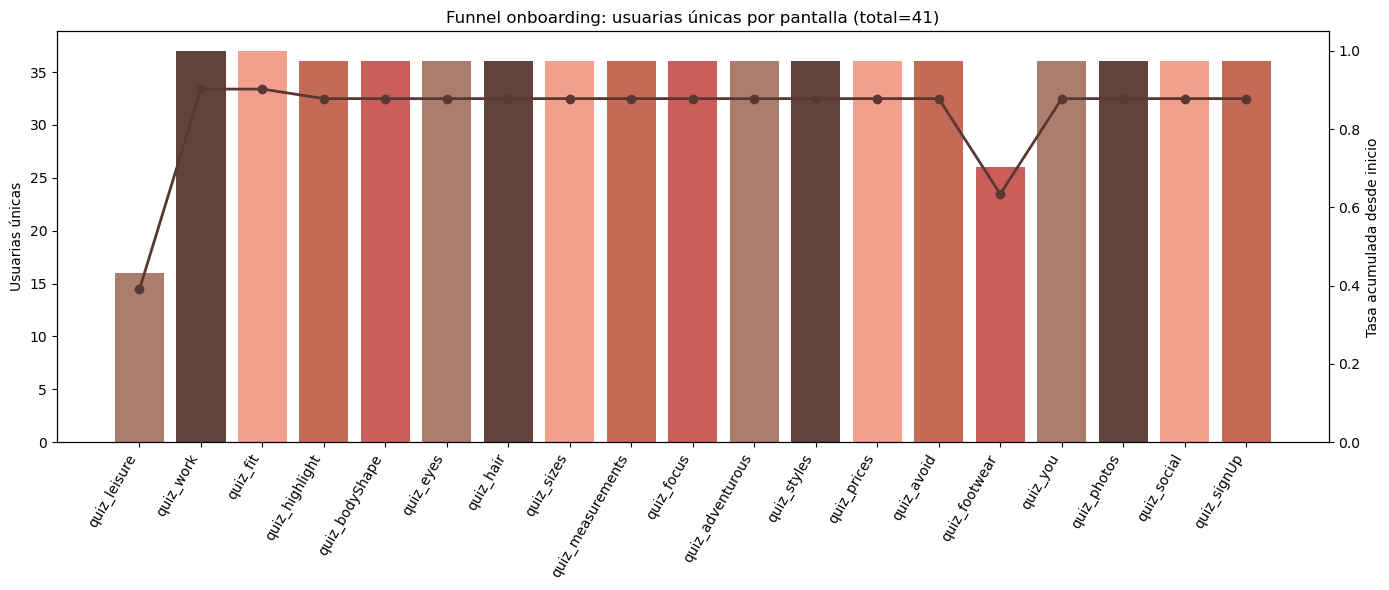

In [14]:
# 8.1 Funnel: usuarias + tasa acumulada
plot_bar_with_line(
    x_labels=funnel["section"].tolist(),
    bars=funnel["users"].tolist(),
    line=funnel["from_start_rate"].fillna(0).tolist(),
    title=f"Funnel onboarding: usuarias únicas por pantalla (total={total_users})",
    y1_label="Usuarias únicas",
    y2_label="Tasa acumulada desde inicio",
    line_as_percent=True,
    save_path="01_funnel_users_rate.png"
)


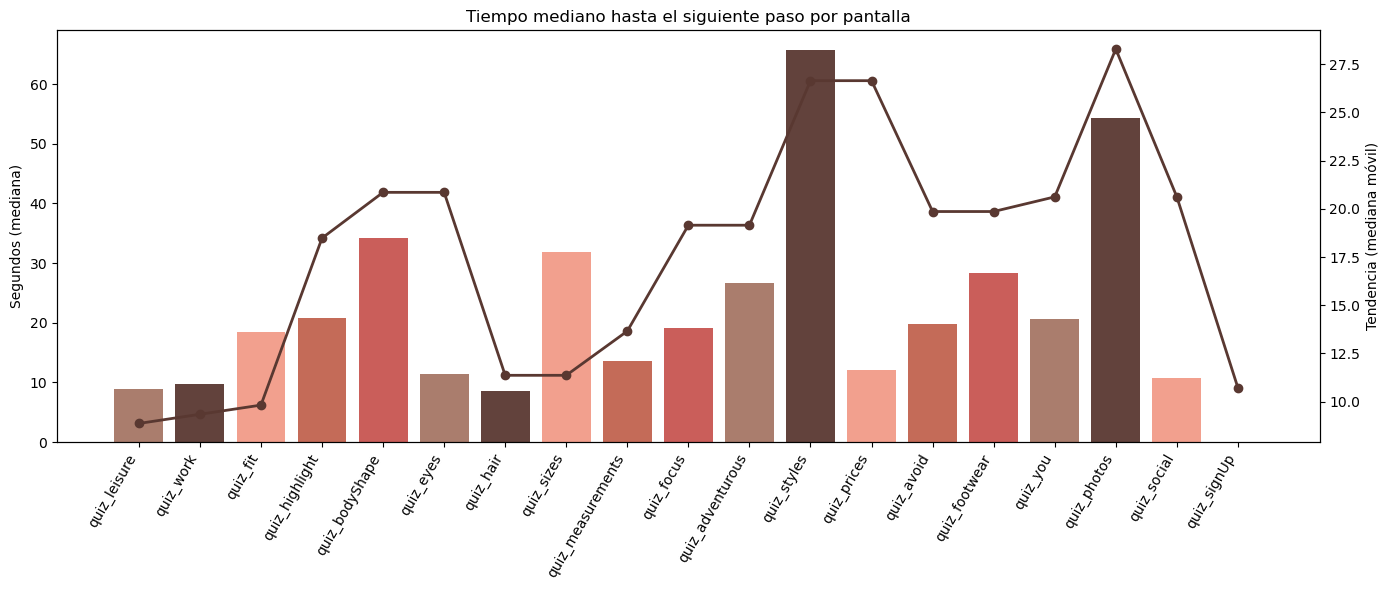

In [15]:
# 8.2 Tiempos: mediana + tendencia (mediana móvil)
plot_bar_with_line(
    x_labels=time_stats["section"].tolist(),
    bars=time_stats["median_time_to_next"].fillna(0).tolist(),
    line=time_stats["median_time_to_next"].fillna(0).rolling(3, min_periods=1).median().tolist(),
    title="Tiempo mediano hasta el siguiente paso por pantalla",
    y1_label="Segundos (mediana)",
    y2_label="Tendencia (mediana móvil)",
    save_path="03_median_time_by_screen.png"
)


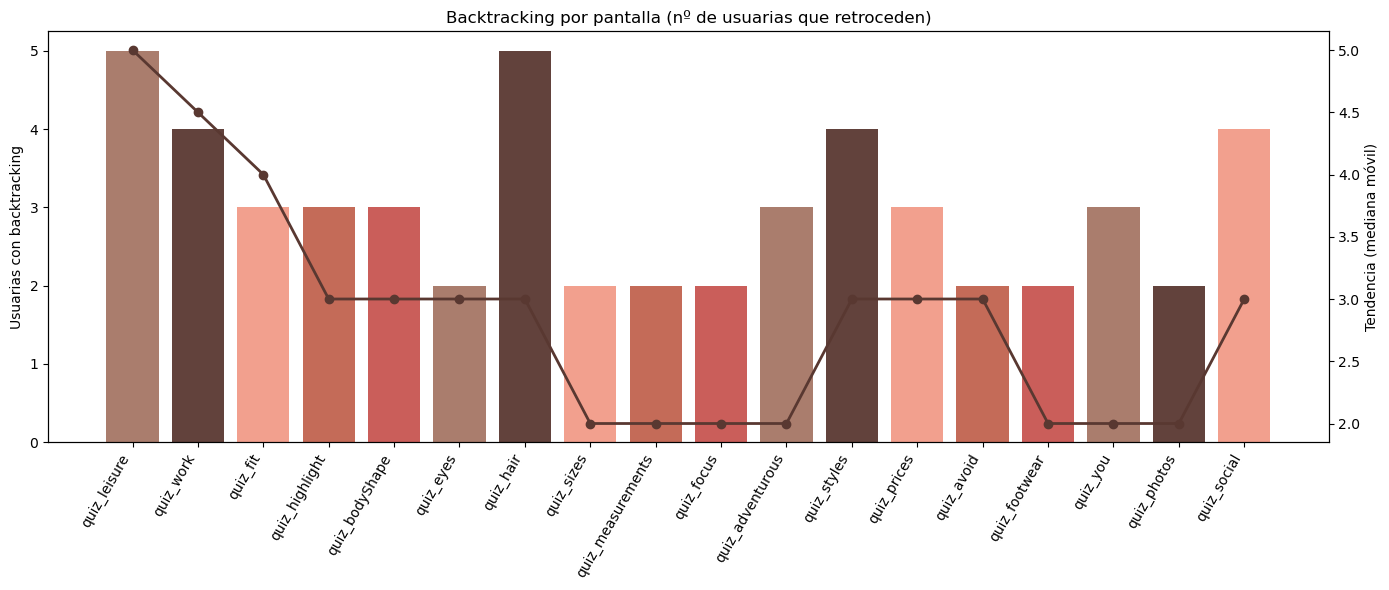

In [16]:
# 8.3 Backtracking: nº usuarias + tendencia
plot_bar_with_line(
    x_labels=backtrack_stats["section"].tolist(),
    bars=backtrack_stats["n_backtracks"].fillna(0).tolist(),
    line=backtrack_stats["n_backtracks"].fillna(0).rolling(3, min_periods=1).median().tolist(),
    title="Backtracking por pantalla (nº de usuarias que retroceden)",
    y1_label="Usuarias con backtracking",
    y2_label="Tendencia (mediana móvil)",
    save_path="04_backtracking_by_screen.png"
)

,section,users,from_prev_rate,median_time_to_next,n_backtracks,friction_score
11,quiz_styles,36,1.000000,65.715336,4.0,0.903799
16,quiz_photos,36,1.000000,54.285818,2.0,0.676837
4,quiz_bodyShape,36,1.000000,34.177424,3.0,0.593841
0,quiz_leisure,16,NaN,8.864713,5.0,0.541247
6,quiz_hair,36,1.000000,8.616449,5.0,0.539358
10,quiz_adventurous,36,1.000000,26.651334,3.0,0.536578
7,quiz_sizes,36,1.000000,31.851825,2.0,0.506146
14,quiz_footwear,26,0.722222,28.292077,2.0,0.505262
3,quiz_highlight,36,0.972973,20.856579,3.0,0.495037
17,quiz_social,36,1.000000,10.716674,4.0,0.485338


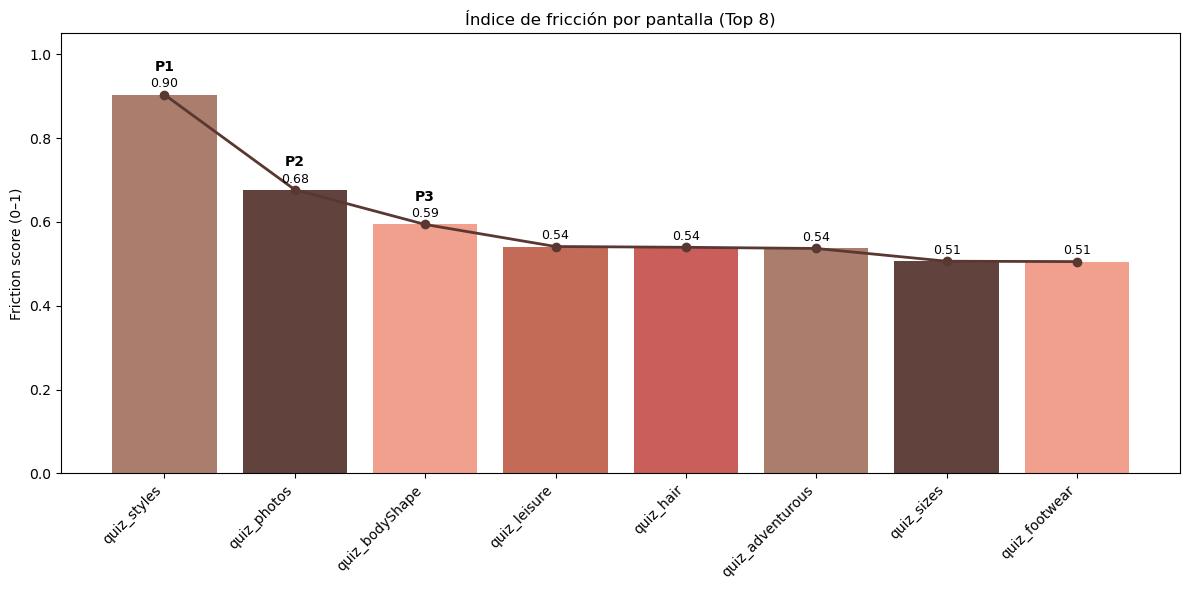

In [17]:
def minmax(s):
    if s.max() == s.min():
        return s * 0
    return (s - s.min()) / (s.max() - s.min())

tmp = funnel.merge(time_stats[["step_order", "median_time_to_next"]], on="step_order", how="left")
bt = backtrack_stats[["section", "n_backtracks"]].copy()

tmp = tmp.merge(bt, on="section", how="left").fillna({"n_backtracks": 0, "median_time_to_next": 0})

tmp["time_norm"] = minmax(tmp["median_time_to_next"])
tmp["bt_norm"]   = minmax(tmp["n_backtracks"])
tmp["drop_norm"] = minmax(1 - tmp["from_prev_rate"].fillna(1))

# Pesos (ajustables)
tmp["friction_score"] = 0.5 * tmp["time_norm"] + 0.35 * tmp["bt_norm"] + 0.15 * tmp["drop_norm"]

display(tmp.sort_values("friction_score", ascending=False)[
    ["section", "users", "from_prev_rate", "median_time_to_next", "n_backtracks", "friction_score"]
].head(10))

# Gráfico pro (Top 8)
tmp_top = tmp.sort_values("friction_score", ascending=False).head(8).copy()
labels = tmp_top["section"].tolist()
scores = tmp_top["friction_score"].tolist()
x = np.arange(len(labels))
bar_colors = [PALETTE[i % len(PALETTE)] for i in range(len(scores))]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x, scores, color=bar_colors, alpha=0.95)
ax.plot(x, scores, marker="o", linewidth=2, color=PALETTE[1])

ax.set_title("Índice de fricción por pantalla (Top 8)")
ax.set_ylabel("Friction score (0–1)")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylim(0, 1.05)

priority = {0: "P1", 1: "P2", 2: "P3"}
for i, v in enumerate(scores):
    if i in priority:
        ax.text(i, v + 0.05, priority[i], ha="center", va="bottom",
                fontsize=10, fontweight="bold")
    ax.text(i, v + 0.01, f"{v:.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("06_friction_score_top8.png", dpi=200, bbox_inches="tight")
plt.show()


In [18]:
backtrack_stats.to_csv("Web/static/backtrack_stats.csv")
time_stats.to_csv("Web/static/time_stats.csv")